## Salish Sea Maps
This notebook plots various maps relevant to the SalishSeaCast project. The first map is a general study area map. The second map shows the model domain and bathymetry. The third map shows the Strait of Georgia with relevant observation platform locations overplotted.

In [1]:
from salishsea_tools import nc_tools, viz_tools
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy.io import loadmat
import numpy as np
import xarray as xr

%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 14

#### Boilerplate Functions
Annotations

In [3]:
def plot_annotations(ax, m, annotations, zorder=None):
    """
    """
    
    # Plot Locations
    for annotation_label, annotation in annotations.items():
        ax.text(*annotation['text'], annotation_label, transform=ax.transAxes,
                fontsize=annotation['font']+1, rotation=annotation['rotate'], zorder=zorder)
        if annotation['marker'] is not None:
            x, y = m(*annotation['marker'])
            ax.plot(x, y, 'ko', markersize=8, markerfacecolor=annotation['color'], zorder=zorder)
        if annotation['arrow'] is not None:
            ax.arrow(*annotation['arrow'], head_width=0.01, fc='k', transform=ax.transAxes, zorder=zorder)

Background basemap

In [4]:
def plot_basemap(ax, w_map, lons=None, lats=None, offset=[None, None], zorder=[0, 1, 2]):
    """
    """
    
    # Define map window
    lon_0 = (w_map[1] - w_map[0]) / 2 + w_map[0]
    lat_0 = (w_map[3] - w_map[2]) / 2 + w_map[2]

    # Make projection
    m = Basemap(projection='lcc', resolution='h',
                lon_0=lon_0, lat_0=lat_0,
                llcrnrlon=w_map[0], urcrnrlon=w_map[1],
                llcrnrlat=w_map[2], urcrnrlat=w_map[3], ax=ax)
    
    # Default lon/lat intervals
    if lons is None:
        lons = np.floor([w_map[0], w_map[1] + 1])
    if lats is None:
        lats = np.floor([w_map[2], w_map[3] + 1])
    
    # Add features and labels
    m.drawcoastlines(zorder=zorder[1])
    m.fillcontinents(color='Burlywood', zorder=zorder[0])
    m.drawmeridians(np.arange(*lons), labels=[0, 0, 1, 0], color='dimgray', yoffset=offset[1], zorder=zorder[2])
    m.drawparallels(np.arange(*lats), labels=[0, 1, 0, 0], color='dimgray', xoffset=offset[0], zorder=zorder[2])
    
    return m

#### Map Functions
Plots study area

In [5]:
def plot_map(ax, cst, bounds, grid):
    """Plot Strait of Georgia study area on Basemap object
    """
    
    # Plot Basemap
    w_map = [-127, -121, 46.5, 51.5]
    m = plot_basemap(ax, w_map, offset=[-30000, -15000], zorder=[0, 1, 7])
    
    # Plot Fraser River
    for bound in bounds:
        i_old = 0
        for i in np.argwhere(np.isnan(cst['ncst'][bound[0]:bound[1], 1]))[:, 0]:
            x, y = m(cst['ncst'][bound[0]:bound[1], 0][i_old:i],
                     cst['ncst'][bound[0]:bound[1], 1][i_old:i])
            ax.plot(x, y, 'k-')
            i_old = i + 1
    
    # Convert lon/lat to x, y
    x, y = m(grid['nav_lon'].values, grid['nav_lat'].values)

    # Overlay model domain
    C = ax.contourf(x, y, grid['Bathymetry'], range(0, 525, 25), cmap='Blues', zorder=2)
    ax.contourf(x, y, grid['Bathymetry'], [-0.01, 0.01], colors='lightgray', zorder=3)
    ax.contour( x, y, grid['Bathymetry'], [0], colors='Black', zorder=4)

    # Colorbar
    fig.subplots_adjust(bottom=0.15)
    cax = fig.add_axes([0.15, 0.1, 0.73, 0.01])
    cbar = fig.colorbar(C, cax=cax, orientation='horizontal', label='Depth [m]')
    cbar.set_ticks(range(0, 550, 50))

    # Box around model domain
    ax.plot(x[ :,  0], y[ :,  0], 'k-', zorder=6)
    ax.plot(x[ :, -1], y[ :, -1], 'k-', zorder=6)
    ax.plot(x[ 0,  :], y[ 0,  :], 'k-', zorder=6)
    ax.plot(x[-1,  :], y[-1,  :], 'k-', zorder=6)

    # Define Significant Landmarks and Locations
    annotations = {
        'Pacific\nOcean'     : {'text': [0.10, 0.250], 'font': 14, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
        'British\nColumbia'  : {'text': [0.65, 0.850], 'font': 14, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
        #'Vancouver\nIsland'  : {'text': [0.12, 0.680], 'font': 14, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
        'Vancouver\nIsland'  : {'text': [0.40, 0.470], 'font': 14, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
        'Washington\nState'  : {'text': [0.70, 0.030], 'font': 14, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
        'Coast Mountains'    : {'text': [0.60, 0.800], 'font': 13, 'rotate': -40, 'color': 'r', 'marker': None, 'arrow': None},
        'Strait of Georgia'  : {'text': [0.50, 0.575], 'font': 13, 'rotate': -40, 'color': 'r', 'marker': None, 'arrow': None},
        'Juan de Fuca Strait': {'text': [0.36, 0.400], 'font': 13, 'rotate': -21, 'color': 'r', 'marker': None, 'arrow': None},
        'Fraser River'       : {'text': [0.80, 0.530], 'font': 13, 'rotate':  15, 'color': 'r', 'marker': None, 'arrow': None},
        'Johnstone Strait'   : {'text': [0.08, 0.780], 'font': 13, 'rotate': -15, 'color': 'r', 'marker': None, 'arrow': None},
        #'Howe\nSound'        : {'text': [0.62, 0.640], 'font': 13, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
        'Howe\nSound'        : {'text': [0.56, 0.630], 'font': 13, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
        'Bute\nInlet'        : {'text': [0.41, 0.850], 'font': 13, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
        #'Alberni\nInlet'     : {'text': [0.40, 0.500], 'font': 13, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
        #'Puget\nSound'       : {'text': [0.82, 0.150], 'font': 13, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
        'Puget\nSound'       : {'text': [0.82, 0.190], 'font': 13, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
        'Hood\nCanal'        : {'text': [0.62, 0.210], 'font': 13, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
        'Desolation\nSound'  : {'text': [0.43, 0.720], 'font': 13, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
        #'Vancouver'          : {'text': [0.69, 0.540], 'font': 12, 'rotate':   0, 'color': 'r', 'marker': [-123.10, 49.25], 'arrow': None},
        'Vancouver'          : {'text': [0.71, 0.540], 'font': 12, 'rotate':   0, 'color': 'r', 'marker': [-123.10, 49.25], 'arrow': None},
        'Victoria'           : {'text': [0.53, 0.380], 'font': 12, 'rotate':   0, 'color': 'r', 'marker': [-123.37, 48.43], 'arrow': None},
        'Hope'               : {'text': [0.93, 0.550], 'font': 12, 'rotate':   0, 'color': 'r', 'marker': [-121.44, 49.39], 'arrow': None},
    }
    
    # Plot Annotations
    plot_annotations(ax, m, annotations, zorder=7)

Plots SalishSeaCast domain

In [6]:
def plot_domain(ax, grid):
    """Plot SalishSeaCast domain and bathymetry on Basemap object
    """
    
    # Plot Basemap
    w_map = [-126.3, -121, 46.8, 51.1]
    m = plot_basemap(ax, w_map, offset=[-30000, -15000], zorder=[0, 1, 5])

    # Convert lon/lat to x, y
    x, y = m(grid['nav_lon'].values, grid['nav_lat'].values)

    # Overlay model domain
    C = ax.contourf(x, y, grid['Bathymetry'], range(0, 525, 25), cmap='Blues', zorder=2)
    ax.contourf(x, y, grid['Bathymetry'], [-0.01, 0.01], colors='lightgray', zorder=3)
    ax.contour( x, y, grid['Bathymetry'], [0], colors='Black', zorder=4)

    # Colorbar
    fig.subplots_adjust(bottom=0.15)
    cax = fig.add_axes([0.15, 0.1, 0.73, 0.01])
    cbar = fig.colorbar(C, cax=cax, orientation='horizontal', label='Depth [m]')
    cbar.set_ticks(range(0, 550, 50))

    # Box around model domain
    ax.plot(x[ :,  0], y[ :,  0], 'k-', zorder=6)
    ax.plot(x[ :, -1], y[ :, -1], 'k-', zorder=6)
    ax.plot(x[ 0,  :], y[ 0,  :], 'k-', zorder=6)
    ax.plot(x[-1,  :], y[-1,  :], 'k-', zorder=6)
    
    # Abbreviations
    JdFboundary = 'Juan de Fuca Strait\nOpen Boundary'
    JSboundary = 'Johnstone Strait\nOpen Boundary'
    
    # Define Significant Landmarks and Locations
    annotations = {
        JdFboundary    : {'text': [0.05, 0.30], 'font': 13, 'rotate':0, 'color': 'r', 'marker': None, 'arrow': [0.20, 0.35,  0.08,  0.040]},
        JSboundary     : {'text': [0.01, 0.43], 'font': 13, 'rotate':0, 'color': 'r', 'marker': None, 'arrow': [0.06, 0.47,  0.00,  0.360]},
        'Fraser\nRiver': {'text': [0.70, 0.70], 'font': 13, 'rotate':0, 'color': 'r', 'marker': None, 'arrow': [0.70, 0.69, -0.04, -0.035]},
    }
    
    # Plot Annotations
    plot_annotations(ax, m, annotations, zorder=3)

Plots the station map

In [7]:
def plot_stations(ax, cst, bounds):
    """Plot Strait of Georgia observing platform locations
    """

    # Plot Basemap
    w_map = [-125.3, -122.8, 48.25, 50.15]
    m = plot_basemap(ax, w_map, lons=[-125, -122, 0.5], lats=[48, 51, 0.5])
    
    # Plot Fraser River
    for bound in bounds:
        i_old = 0
        for i in np.argwhere(np.isnan(cst['ncst'][bound[0]:bound[1], 1]))[:, 0]:
            x, y = m(cst['ncst'][bound[0]:bound[1], 0][i_old:i],
                     cst['ncst'][bound[0]:bound[1], 1][i_old:i])
            ax.plot(x, y, 'k-')
            i_old = i + 1
    
    # Abbreviate Ferry Names
    TWSB_ferry = 'Tsawwassen/\nSwartz Bay\nFerry'
    TWNM_ferry = 'Tsawwassen/\nNanaimo\nFerry'
    HBNM_ferry = 'Horseshoe Bay/\nNanaimo\nFerry'

    # Define Stations
    annotations = {
        'Quadra\nIsland'  : {'text': [0.300, 0.960], 'font': 12, 'rotate': 0, 'color': 'magenta', 'marker': [-125.22, 50.11], 'arrow': [0.29, 0.98, -0.21, 0]},
        'Georgina\nPoint' : {'text': [0.840, 0.320], 'font': 12, 'rotate': 0, 'color': 'cyan', 'marker': [-123.29, 48.87], 'arrow': None},
        'Westshore'       : {'text': [0.760, 0.385], 'font': 12, 'rotate': 0, 'color': 'cyan', 'marker': [-123.17, 49.02], 'arrow': None},
        'Iona'            : {'text': [0.785, 0.510], 'font': 12, 'rotate': 0, 'color': 'cyan', 'marker': [-123.21, 49.22], 'arrow': None},
        'Race Rocks'      : {'text': [0.740, 0.020], 'font': 12, 'rotate': 0, 'color': 'r'   , 'marker': [-123.53, 48.30], 'arrow': None},
        'Saturna\nIsland' : {'text': [0.900, 0.290], 'font': 12, 'rotate': 0, 'color': 'r'   , 'marker': [-123.08, 48.78], 'arrow': None},
        'Sandheads'       : {'text': [0.730, 0.460], 'font': 12, 'rotate': 0, 'color': 'r'   , 'marker': [-123.30, 49.11], 'arrow': None},
        'YVR'             : {'text': [0.870, 0.505], 'font': 12, 'rotate': 0, 'color': 'r'   , 'marker': [-123.18, 49.20], 'arrow': None},
        'Halibut Bank'    : {'text': [0.560, 0.580], 'font': 12, 'rotate': 0, 'color': 'r'   , 'marker': [-123.72, 49.34], 'arrow': None},
        'Pam Rocks'       : {'text': [0.830, 0.650], 'font': 12, 'rotate': 0, 'color': 'r'   , 'marker': [-123.30, 49.49], 'arrow': None},
        'Entrance Island' : {'text': [0.610, 0.505], 'font': 12, 'rotate': 0, 'color': 'r'   , 'marker': [-123.81, 49.21], 'arrow': None},
        'Sisters\nIslets' : {'text': [0.300, 0.600], 'font': 12, 'rotate': 0, 'color': 'r'   , 'marker': [-124.44, 49.49], 'arrow': None},
        'Sentry Shoal'    : {'text': [0.130, 0.850], 'font': 12, 'rotate': 0, 'color': 'r'   , 'marker': [-124.99, 49.91], 'arrow': None},
        'Victoria'        : {'text': [0.780, 0.060], 'font': 12, 'rotate': 0, 'color': 'lime', 'marker': [-123.37, 48.42], 'arrow': None},
        'Patricia\nBay'   : {'text': [0.775, 0.210], 'font': 12, 'rotate': 0, 'color': 'lime', 'marker': [-123.45, 48.65], 'arrow': None},
        'Vancouver'       : {'text': [0.890, 0.525], 'font': 12, 'rotate': 0, 'color': 'lime', 'marker': [-123.12, 49.28], 'arrow': None},
        'New\nWestminster': {'text': [0.960, 0.445], 'font': 12, 'rotate': 0, 'color': 'lime', 'marker': [-122.90, 49.19], 'arrow': None},
        'Point Atkinson'  : {'text': [0.820, 0.575], 'font': 12, 'rotate': 0, 'color': 'lime', 'marker': [-123.25, 49.33], 'arrow': None},
        'Nanaimo'         : {'text': [0.450, 0.475], 'font': 12, 'rotate': 0, 'color': 'lime', 'marker': [-123.94, 49.16], 'arrow': None},
        'Neah Bay'        : {'text': [0.280, 0.070], 'font': 12, 'rotate': 0, 'color': 'lime', 'marker': [-124.62, 48.37], 'arrow': None},
        'Campbell\nRiver' : {'text': [0.010, 0.800], 'font': 12, 'rotate': 0, 'color': 'lime', 'marker': [-125.25, 50.05], 'arrow': [0.035, 0.84, 0.00, 0.085]},
        'Central\nNode'   : {'text': [0.520, 0.350], 'font': 12, 'rotate': 0, 'color': 'cyan', 'marker': [-123.43, 49.04], 'arrow': [0.60, 0.38, 0.13, 0.03]},
        'East\nNode'      : {'text': [0.600, 0.320], 'font': 12, 'rotate': 0, 'color': 'cyan', 'marker': [-123.32, 49.04], 'arrow': [0.65, 0.34, 0.13, 0.065]},
        'Delta\nNode'     : {'text': [0.540, 0.415], 'font': 12, 'rotate': 0, 'color': 'cyan', 'marker': [-123.33, 49.08], 'arrow': [0.60, 0.435, 0.17, 0.00]},
        TWSB_ferry        : {'text': [0.520, 0.220], 'font': 12, 'rotate': 0, 'color': 'r'   , 'marker': None            , 'arrow': [0.65, 0.25, 0.13, 0.04]},
        TWNM_ferry        : {'text': [0.370, 0.385], 'font': 12, 'rotate': 0, 'color': 'r'   , 'marker': None            , 'arrow': [0.50, 0.445, 0.13, 0.04]},
        HBNM_ferry        : {'text': [0.260, 0.480], 'font': 12, 'rotate': 0, 'color': 'r'   , 'marker': None            , 'arrow': [0.44, 0.53, 0.17, 0.00]},
    }

    # Plot Annotations
    plot_annotations(ax, m, annotations, zorder=3)

    # Plot Ferry Tracks
    ferry = loadmat('/ocean/jieliu/research/meopar/ONC_ferries/HBDB/HBDB_NAV20170119.mat')
    x, y = m(ferry['output'][0][0][3][0][0][6][1640:2210], ferry['output'][0][0][2][0][0][6][1640:2210])
    ax.plot(x, y, 'k--')
    ferry = loadmat('/ocean/jieliu/research/meopar/ONC_ferries/HBDB/TWDP_NAV20160117.mat')
    x, y = m(ferry['output'][0][0][1][0][0][6][1280:1970], ferry['output'][0][0][0][0][0][6][1280:1970])
    ax.plot(x, y, 'k--')
    ferry = loadmat('/ocean/jieliu/research/meopar/ONC_ferries/TWSB/TWSB_NAV20161007.mat')
    x, y = m(ferry['output'][0][0][1][0][0][6][1280:1970], ferry['output'][0][0][0][0][0][6][1280:1970])
    ax.plot(x, y, 'k--')

#### Make Maps
First load grid and coastline files

In [9]:
# Load NEMO grid
grid_NEMO = xr.open_dataset(
    '/data/bmoorema/MEOPAR/NEMO-forcing/grid/bathy_downonegrid2.nc', mask_and_scale=False)

# Load Fraser coastline
#PNWrivers = loadmat('/ocean/rich/more/mmapbase/bcgeo/PNWrivers.mat')

Plot the region map

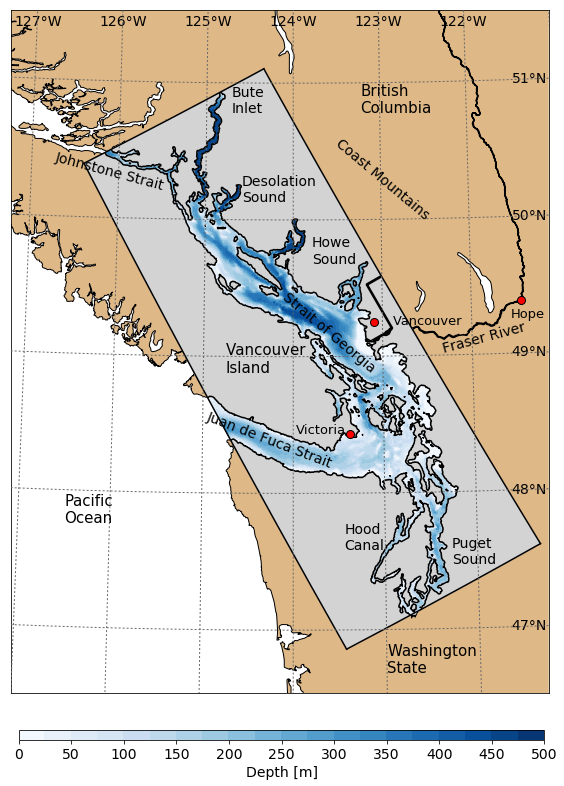

In [25]:
# Define Fraser coastline regions
bounds = [[0, 26000], [61500, 77000], [107500, 114000], [200000, 203000], [326000, 327000]]

# Make figure window
fig, ax = plt.subplots(1, 1, figsize=(10, 13))

# Plot Model Domain
plot_map(ax, PNWrivers, bounds, grid_NEMO)

fig.savefig('/home/bmoorema/Desktop/map.png', transparent=True, dpi=300, bbox_inches='tight')

Plot the SalishSeaCast domain.

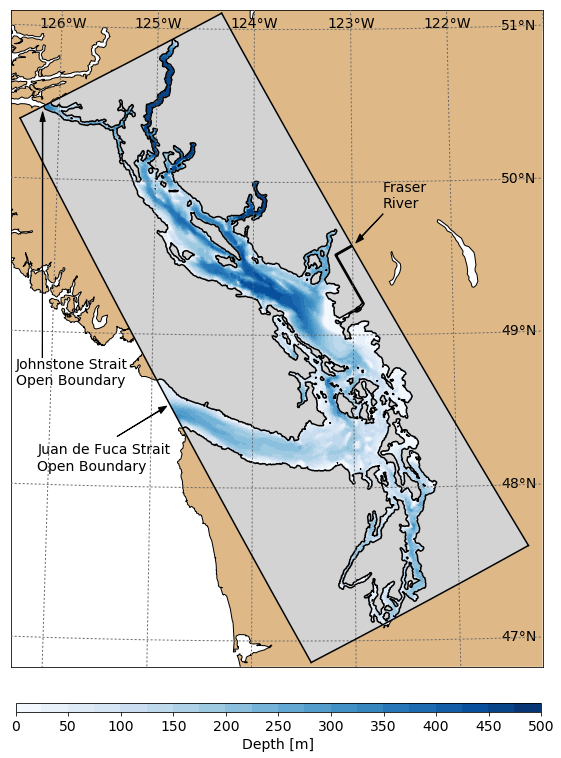

In [10]:
# Make figure window
fig, ax = plt.subplots(1, 1, figsize=(10, 12.5))

# Plot Model Domain
plot_domain(ax, grid_NEMO)

fig.savefig('/home/bmoorema/Desktop/domain.eps', transparent=True, dpi=300, bbox_inches='tight')

Plot station locations.

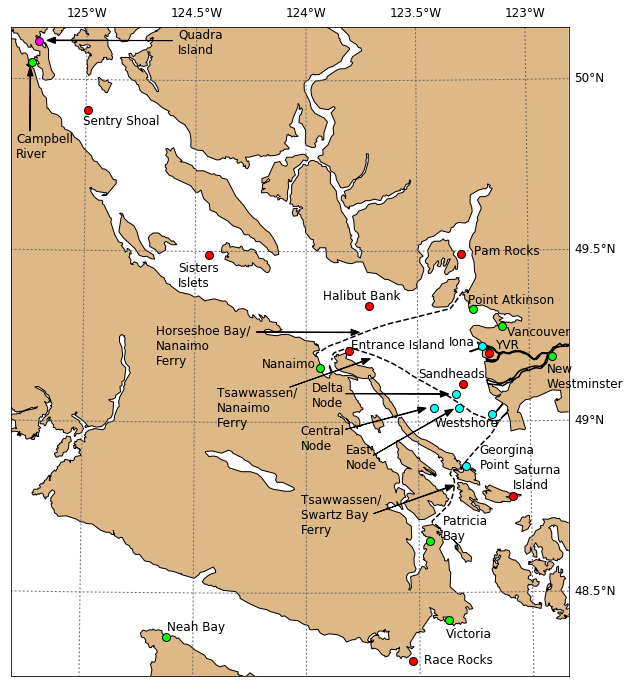

In [54]:
# Define Fraser coastline regions
bounds = [[72000, 77000], [200000, 203000], [326000, 327000]]

# Make figure window
fig, ax = plt.subplots(1, 1, figsize=(10, 13))

plot_stations(ax, PNWrivers, bounds)

fig.savefig('/home/bmoorema/Desktop/stations.eps', transparent=True, dpi=300, bbox_inches='tight')